<a href="https://colab.research.google.com/github/proxolo1/xplorer/blob/main/AI_Voice_Cloning_Introduction_%5BPUBLIC%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

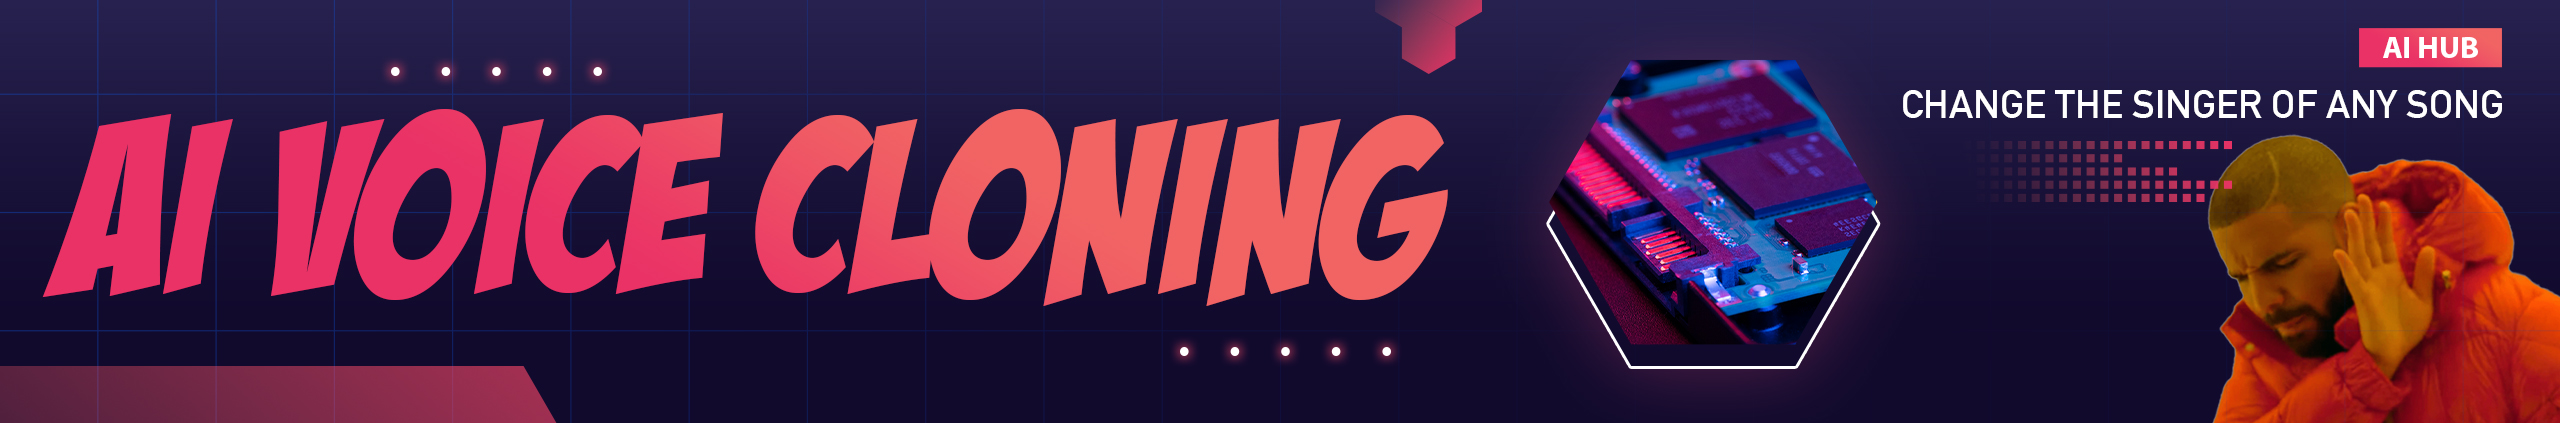

# **Getting Started**

This model is intented to be a very simple appraoch for anyone who is trying to use AI to clone voices. Simply follow the simple steps below and you will be able to sound like Drake in no time.

### **Tips**

To get the best sounding clone audio, you should provide an audio clip which is a clean acapella (doesn't have any background music/instrumentals) in it. There are a lot of acapella versions of your favorite songs on YouTube! Or you can always record yourself!

<br />

Lastly, join our [Discord Server @ AI Hub](https://discord.gg/aihub) and share your music!

<div>Made By $easons and Subraiz</div>

In [ ]:
#@title Connect Your Google Account - Hit the Play Button (Only Need to Run Once)

#@title Initial Setup - Hit the Play Button (Only Need to Run Once) - This will take a couple of minutes
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
import time
from google.colab import drive as gdrive

SHORTCUT_FILENAME = "so-vits-svc-fork-ai-hub"

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

drive_service = build('drive', 'v3')

url = "https://drive.google.com/drive/folders/1-lw4MVk1bb6XVafbsVx9hRoMVOHmsnEv"
folder_id = url.split('/')[-1]

# Search for a shortcut file with the same title in the user's root folder
query = f"title='{SHORTCUT_FILENAME}' and mimeType='application/vnd.google-apps.shortcut' and trashed=false and 'root' in parents"
file_list = drive.ListFile({'q': query}).GetList()


# Create a GoogleDriveFile object for the folder
folder = drive.CreateFile({'id': folder_id})

if len(file_list) == 0:
    # Create a shortcut to the folder in the user's root folder
    shortcut_metadata = {
        'title': SHORTCUT_FILENAME,
        'parents': [{
            'kind': 'drive#fileLink',
            'id': 'root'
        }],
        'mimeType': 'application/vnd.google-apps.shortcut',
        'shortcutDetails': {
            'targetId': folder_id,
            'targetMimeType': 'application/vnd.google-apps.folder'
        }
    }
    shortcut = drive.CreateFile(shortcut_metadata)
    shortcut.Upload()

gdrive.mount('/drive')

# Wait for the drive to be mounted
time.sleep(2)

In [ ]:
import os
import gdown
from os.path import exists
from tqdm import tqdm
import urllib.request
from google.colab import drive as gdrive
#@title Initial Setup - Hit the Play Button (Only Need to Run Once) - This will take a couple of minutes
print("Setup began. Please wait.")
!python -m pip install -q -U pip wheel &> /dev/null
%pip install -q -U ipython &> /dev/null
%pip install -q -U so-vits-svc-fork &> /dev/null


!rm -R /content/sample_data/ &> /dev/null
gdrive.mount("/drive", force_remount=True)
print("Setup finished!")

In [ ]:
#@title Cloning Your Audio - Open the file explorer on the left of your screen and drag-and-drop an audio file anywhere. Then hit the play button below.
from ipywidgets import widgets
import copy
import json
import glob
import os
import time
import threading
from IPython.display import Audio, display, HTML, FileLink
from pathlib import Path
import subprocess
import shutil
from google.colab import files
from ipywidgets import TwoByTwoLayout
import re

SEGMENT_LENGTH = 60

SHORTCUT_FILENAME = "so-vits-svc-fork-ai-hub"
MODELS_DIR = f"/drive/MyDrive/{SHORTCUT_FILENAME}"

MUSIC_EXTENSIONS = ['.mp3', '.wav', '.flac', '.aac']

SEGMENTS_DIRNAME = f"/content/segments"
INFERENCE_OUTPUT_DIRNAME = "/content/inference_output"

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def is_valid_filename(filename):
    # Check if the filename contains any invalid characters
    if re.search(r'[<>:"/\\|?*\x00-\x1f]', filename):
        return False
    # Check if the filename contains any hyphens, spaces, or parentheses
    if re.search(r'[-\s()]', filename):
        return False
    return True

def clean_filename(filename):
    # Extract the filename from the path
    basename = os.path.basename(filename)
    # Remove any invalid characters from the filename
    cleaned_basename = re.sub(r'[<>:"/\\|?*\x00-\x1f]', '', basename)
    # Replace any hyphens or spaces with underscores
    cleaned_basename =  re.sub(r'[-\s]+', '_', cleaned_basename)
    # Remove any parentheses from the filename
    cleaned_basename = re.sub(r'[\(\)]+', '', cleaned_basename)
    # Remove any apostrophes and quotes and $
    cleaned_basename = cleaned_basename.replace("'", "").replace('"', '').replace("$", "")
    # Remove all periods except the last one
    cleaned_basename_arr = cleaned_basename.split()
    for i in range(len(cleaned_basename_arr)):
      if i != len(cleaned_basename_arr)-1:
          cleaned_basename_arr[i] = cleaned_basename_arr[i].replace(".", "")
    cleaned_basename = " ".join(cleaned_basename_arr)
    # Return the full path with the cleaned filename
    return os.path.join(os.path.dirname(filename), cleaned_basename)

def get_audio_files():
  audio_files = []
  for root, dirs, files in os.walk("/content"):
    for filename in files:
      file_extension = os.path.splitext(filename)[1]
      if file_extension.lower() in MUSIC_EXTENSIONS and "output" not in filename:
        audio_files.append(filename)

  return audio_files

def get_speakers():
  speakers = []
  for _,dirs,_ in os.walk(MODELS_DIR):
    for folder in dirs:
      cur_speaker = {}
      # Look for G_****.pth
      g = glob.glob(os.path.join(MODELS_DIR,folder,'G_*.pth'))
      if not len(g):
        continue
      cur_speaker["model_path"] = g[0]
      cur_speaker["model_folder"] = folder

      # Look for *.pt (clustering model)
      clst = glob.glob(os.path.join(MODELS_DIR,folder,'*.pt'))
      if not len(clst):
        cur_speaker["cluster_path"] = ""
      else:
        cur_speaker["cluster_path"] = clst[0]

      # Look for config.json
      cfg = glob.glob(os.path.join(MODELS_DIR,folder,'*.json'))
      if not len(cfg):
        continue
      cur_speaker["cfg_path"] = cfg[0]
      with open(cur_speaker["cfg_path"]) as f:
        try:
          cfg_json = json.loads(f.read())
        except Exception as e:
          print("Malformed config json in "+folder)
        for name, i in cfg_json["spk"].items():
          cur_speaker["name"] = name
          cur_speaker["id"] = i
          if not name.startswith('.'):
            speakers.append(copy.copy(cur_speaker))

    return sorted(speakers, key=lambda x:x["name"].lower())

def slice_audio(filepath):
    assert os.path.exists(filepath), f"Could not find {filepath}. Make sure you've entered the correct filename."
    # Get the filename and extension of the input file
    filename, extension = os.path.splitext(filepath)
    filename = filename.split("/")[-1]

    os.makedirs(SEGMENTS_DIRNAME, exist_ok=True)

    # Set the output filename pattern
    output_pattern = f"{SEGMENTS_DIRNAME}/{filename}_%d{extension}"

    # Use ffmpeg to split the audio into segments
    os.system(f"ffmpeg -i {filepath} -f segment -segment_time {SEGMENT_LENGTH} -c copy {output_pattern}")


def get_container_format(filename):
    command = ["ffprobe", "-v", "error", "-select_streams", "v:0", "-show_entries", "format=format_name", "-of", "default=noprint_wrappers=1:nokey=1", filename]
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    if error:
        raise ValueError(f"Error getting container format: {error.decode()}")
    return output.decode().strip()

def run_inference(speaker, f0_method, transpose, noise_scale, cluster_ratio, is_pitch_prediction_enabled):
    loading_bar = display(progress(0, 100), display_id=True)
    model_path = speaker["model_path"]
    config_path = speaker["cfg_path"]
    cluster_path = speaker["cluster_path"]

    all_segs_paths = sorted(Path(SEGMENTS_DIRNAME).glob("*"))

    for index, seg_path in enumerate(all_segs_paths):
      max_load_value = float((index + 1)/len(all_segs_paths)) * 100
      loading_bar.update(progress(max_load_value / 2, 100))
      inference_cmd = f"svc infer {seg_path.absolute()} -m {model_path} -c {config_path} {f'-k {cluster_path} -r {cluster_ratio}' if cluster_path != '' and cluster_ratio > 0 else ''} -t {transpose} --f0-method {f0_method} -n {noise_scale} -o {INFERENCE_OUTPUT_DIRNAME}/{seg_path.name} {'' if is_pitch_prediction_enabled else '--no-auto-predict-f0'}"
      # print(f"\nPerforming inference on... {seg_path.absolute()}\ninference cmd: {inference_cmd}")
      result = subprocess.run(
            inference_cmd.split(),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
          )
      loading_bar.update(progress(max_load_value, 100))

      if result.stderr:
        if "AttributeError" in result.stderr:
          raise Exception(result.stderr + "Make sure your model is not 4.0-v2. This notebook only works on 4.0-v1 models.")

      files_length = len(sorted(Path(SEGMENTS_DIRNAME).glob("*")))
      if files_length == 0:
        raise Exception("An unknown error occured!")


def concatenate_segments(final_filename):
    foldername = Path(INFERENCE_OUTPUT_DIRNAME)
    assert foldername.exists(), "folder doesnt exist. Enter correct foldername"
    all_segs = [f for f in sorted(foldername.glob("**/*")) if f.is_file()]
    try:
      ext = all_segs[0].suffix
      with open(foldername/"concat_list.txt", "w") as f:
        for seg in all_segs:
            f.write('file ' + str(seg.absolute()) + "\n")
      os.system(f"ffmpeg -f concat -safe 0 -i {foldername}/concat_list.txt -codec copy {foldername}/{final_filename}")
    except:
      raise Exception(f'No files found in {foldername} directory')

def cleanup_dirs():
  """
  Deletes all temporary directories created in the splicing and inference-output step
  """
  !rm -R {INFERENCE_OUTPUT_DIRNAME} &> /dev/null
  !rm -R {SEGMENTS_DIRNAME} &> /dev/null
  !rm -R ./so_vits_svc_fork.log &> /dev/null

class InferenceGui():
  def __init__(self):
    # Initialize the background watcher thread as None
    speakers = get_speakers()
    self.is_inferencing = False
    self.final_filename = ""
    self.speakers = speakers if speakers is not None else []
    self.speaker_list = [x["name"] for x in self.speakers]
    self.speaker_dropdown = widgets.Dropdown(
        options = self.speaker_list,
        description="AI Model"
    )

    self.audio_files = get_audio_files()
    self.audio_files_dropdown = widgets.Dropdown(
      options = self.audio_files,
      description="Audio File"
    )

    self.f0_methods = ["crepe", "crepe-tiny", "parselmouth", "dio", "harvest"]
    self.f0_methods_dropdown = widgets.Dropdown(options = self.f0_methods, description="F0 Method")

    self.trans_tx = widgets.IntSlider(
      value=0,
      min=-12,
      max=12,
      step=1,
      description='Transpose',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      readout_format='d'
    )

    self.cluster_ratio_tx = widgets.FloatSlider(
      value=0,
      min=0,
      max=1.0,
      step=0.05,
      description='Cluster Ratio',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
    )

    self.noise_scale_tx = widgets.FloatSlider(
      value=.4,
      min=-2,
      max=2,
      step=.4,
      description='Noise Scale',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
    )

    self.pitch_prediction_checkbox = widgets.Checkbox(
        value=False,
        description='Pitch Prediction',
        disabled=False,
        indent=False
    )

    def convert_cb(btn):
      if (self.is_inferencing):
        return
      self.convert()
    self.convert_btn = widgets.Button(description="Convert")
    self.convert_btn.on_click(convert_cb)

    def clean_cb(btn):
      self.clean()
    self.clean_btn = widgets.Button(description="Clear")
    self.clean_btn.on_click(clean_cb)

    def refresh_files(btn):
      self.update_file_list_dropdown()
    self.refresh_files_btn = widgets.Button(description="Refresh Audio Files")
    self.refresh_files_btn.on_click(refresh_files)

    f0_method_container = widgets.HBox([self.f0_methods_dropdown, widgets.Label(value='Crepe is the default and seems to do better when your input audio is singing and "dio" seems to do well if your input audio is rapping.')])
    transpose_container = widgets.HBox([self.trans_tx, widgets.Label(value="This adjusts the output pitch. A good range would be anywhere betweeen -12 and 12.")])
    cluster_container = widgets.HBox([self.cluster_ratio_tx, widgets.Label(value="Adjust the ratio between sounding like the target's timbre and being clear and articulate to find a suitable trade-off point.")])
    noise_scale_container = widgets.HBox([self.noise_scale_tx, widgets.Label(value="If output sounds buzzy/metallic, try raising the noise scale. If artifacts appear that sound like bad noise reduction/the speaker being dunked in water, reduce the noise scale.")])
    pitch_prediction_container = widgets.HBox([self.pitch_prediction_checkbox, widgets.Label(value="Enable automatic pitch prediction. Leave this unchecked this if you're converting a singing voice.")])

    audio_files_container = widgets.HBox([
        self.audio_files_dropdown,
        self.refresh_files_btn
    ])

    voice_cloning_tab = widgets.VBox([self.speaker_dropdown, audio_files_container])
    advanced_settings_tab = widgets.VBox([f0_method_container, transpose_container, cluster_container, noise_scale_container, pitch_prediction_container])
    tabs = [voice_cloning_tab, advanced_settings_tab]
    tab = widgets.Tab()
    tab.set_title(title="Voice Cloning", index=0)
    tab.set_title(title="Advanced Settings", index=1)
    tab.children = tabs

    buttons_container = widgets.HBox([self.convert_btn, self.clean_btn])

    if (len(self.audio_files) == 0):
      audio_file_error_widget = widgets.HBox([
         widgets.Label(value='Please upload an audio file to clone and press the play button to re-run this cell.')
      ])
      display(audio_file_error_widget)
      return

    display(tab)
    display(buttons_container)

  def update_file_list_dropdown(self):
        self.audio_files = get_audio_files()
        self.audio_files_dropdown.options = self.audio_files

  def clean(self):
    input_filepaths = [f for f in glob.glob('/content/**/*.*', recursive=True)
    if any(f.endswith(ex) for ex in ['.wav','.flac','.mp3','.ogg','.opus'])]
    for f in input_filepaths:
      os.remove(f)
    subprocess.run(['sudo', 'updatedb'])
    self.update_file_list_dropdown()


  def convert(self):
    ts0 = time.time()

    # Prevent a conversion process from one starting if one is already running
    self.is_inferencing = True

    speaker = next(x for x in self.speakers if x["name"] ==
          self.speaker_dropdown.value)
    model_path = os.path.join(os.getcwd(),speaker["model_path"])
    config_path = os.path.join(os.getcwd(),speaker["cfg_path"])
    cluster_path = os.path.join(os.getcwd(),speaker["cluster_path"])
    file_path = os.path.join(os.getcwd(), str(self.audio_files_dropdown.value))
    f0_method = str(self.f0_methods_dropdown.value)
    transpose = int(self.trans_tx.value)
    noise_scale = int(self.noise_scale_tx.value)
    cluster_ratio = float(self.cluster_ratio_tx.value)
    is_pitch_prediction_enabled = self.pitch_prediction_checkbox.value

    if not speaker:
      print("Please select an AI Model.")
      return
    if not self.audio_files_dropdown.value or self.audio_files_dropdown.value == "":
      print("Please select an audio file to clone.")
      return

    if not is_valid_filename(file_path):
      try:
        new_filename = clean_filename(file_path)
        os.rename(file_path, new_filename)
        file_path = new_filename
      except:
        print("Please re run this cell by hitting the play button. An unknown error occured.")

    if os.path.exists(SEGMENTS_DIRNAME) or os.path.exists(INFERENCE_OUTPUT_DIRNAME):
      print(f"Previous {SEGMENTS_DIRNAME} and {INFERENCE_OUTPUT_DIRNAME} folders detected.")
      cleanup_dirs()

    # SLICE AUDIO
    slice_audio(file_path)

    # PERFORM INFERENCE
    os.makedirs("inference_output", exist_ok=True)
    run_inference(speaker, f0_method, transpose, noise_scale, cluster_ratio, is_pitch_prediction_enabled)

    cleaned_speaker_name = speaker['name'].replace(" ", "_")
    final_filename = f"{Path(file_path).stem}_{cleaned_speaker_name}_output{Path(file_path).suffix}"
    self.final_filename = final_filename

    # CONCATENATE FILES IN INFERENCE OUTPUT DIR
    concatenate_segments(final_filename)

    # MOVE FINAL CONCATENATED FILE TO TOP-LEVEL IN CURRENT DIR
    shutil.move(Path(INFERENCE_OUTPUT_DIRNAME, final_filename), Path(final_filename))

    # CLEAN UP
    cleanup_dirs()

    ts1 = time.time()
    print(f"Total Time Elapsed: {ts1 - ts0} seconds")
    print("\n*************************************************************************************************************************")
    print("*************************************************************************************************************************")
    print(f"\nDone! You can download your output file in the file explorer as '{final_filename}' or through the audio player below.")
    print("\n*************************************************************************************************************************")
    print("*************************************************************************************************************************\n")

    audio = Audio(final_filename, autoplay=True)
    display(audio)
    self.is_inferencing = False
    self.update_file_list_dropdown()


gui = InferenceGui()

